In [37]:
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import cv2               as cv

import os
from os.path                  import join, dirname, abspath

import io
import PIL
import tensorflow        as tf


from tensorflow               import keras
from tensorflow.keras         import layers
from tensorflow.keras.models  import Sequential
from PIL                      import ImageChops
from google.cloud             import storage
from mushroom_learning.params import BUCKET_NAME


import pathlib

# Api imports
import requests

# GCP .env path related things
from dotenv import load_dotenv, find_dotenv

In [2]:
def get_images_directory(directory):
    data_dir = pathlib.Path(directory)
    return data_dir

# Look at directory

In [3]:
! pwd

/home/danielsptanner/code/DSP-Tan/mushroom_learning/notebooks


**We don't have to look at it. But the images are at ../raw_data/images/**

## Find number of species

### linux method

In [4]:
ls  ../raw_data/images/ | wc

   1394    1497   55319


In [5]:
num_species=1394

### Python method

In [6]:
import os, sys

path_to_imgs='../raw_data/images/'

# listing directories
species_dir_list=os.listdir(path_to_imgs)

# renaming directory 
#os.rename("old_name","new_name")
# you can list again after if you like

In [7]:
species_dir_list[1000]

'11081_Pseudoboletus_parasiticus'

In [10]:
#### Count number of species

In [11]:
print(f'We have {len(species_dir_list)} different species')

We have 1394 different species


In [12]:
def find_species(species_name,species_list):
    '''
    This takes a species name as a string, which should have an _ 
    between the genus and species part of the name, and returns 
    its containing directory to you. 
    '''
    for i in species_list:
        if species_name.lower() in i.lower():
            return path_to_imgs+i

In [13]:
amanites=find_species('amanita_muscaria',species_dir_list)
common_morels=find_species('morchella_vulgaris',species_dir_list)
yellow_morels=find_species('morchella_esculenta',species_dir_list)
chick_o_woods=find_species('laetiporus_sulphureus',species_dir_list)
print(amanites)
print(common_morels)
print(yellow_morels)
print(chick_o_woods)

../raw_data/images/10252_Amanita_muscaria
../raw_data/images/45107_Morchella_vulgaris
../raw_data/images/17154_Morchella_esculenta
../raw_data/images/15969_Laetiporus_sulphureus


## Find number of photos of each species

In [14]:
def num_of_species(spec_dir):
    return len( list(os.listdir(spec_dir)) )

In [25]:
print(f"There are {num_of_species(find_species('amanita_muscaria',species_dir_list))} aminita muscarias")
print(f"There are {num_of_species(find_species('amanita_phalloides',species_dir_list))} amanita phalloides (death caps)")
print(f"There are {num_of_species(find_species('morchella_vulgaris',species_dir_list))} morchella vulgaris")
print(f"There are {num_of_species(find_species('morchella_esculenta',species_dir_list))} morchella esculenta")
print(f"There are {num_of_species(find_species('laetiporus_sulphureus',species_dir_list))} chick-o-woods")

There are 163 aminita muscarias
There are 55 amanita phalloides (death caps)
There are 20 morchella vulgaris
There are 68 morchella esculenta
There are 181 chick-o-woods


### Make data frame with spcies and number of photos

In [16]:
spec='species'
num='num'
#print(f'{spec:30} {num:30}')
spec_names=[]
spec_num_phots=[]
for i in species_dir_list:
    #This skips the files folder_analysis.sh and folders.txt which are here and are not directories.
    if 'folder' in i:
        continue
    #print(f'{i:50} {len(list(os.listdir(path_to_imgs+i)))}')
    spec_names.append(i)
    spec_num_phots.append(len(list(os.listdir(path_to_imgs+i))))
    
zipped = list(zip(spec_names, spec_num_phots))
df = pd.DataFrame(zipped, columns=['Name', '# photos'])
df.head()

,Name,# photos
0,11467_Ceriporia_reticulata,18
1,46177_Fomitiporia_hippophaeicola,17
2,13953_Exidia_pithya,21
3,19156_Psathyrella_obtusata,20
4,16423_Leucogyrophana_mollusca,12


### Identify top 20 for choice of what species to detect. 

In [17]:
df.sort_values('# photos',ascending=False).head(15)

,Name,# photos
1141,18882_Plicatura_crispa,442
501,18890_Pluteus_cervinus,419
179,21143_Tricholoma_scalpturatum,414
319,11082_Xerocomellus_chrysenteron,406
564,17233_Mycena_galericulata,375
188,40985_Byssomerulius_corium,374
1367,12919_Cylindrobasidium_laeve,364
725,40392_Armillaria_lutea,352
633,14160_Ganoderma_pfeifferi,342
583,61207_Coprinellus_micaceus,340


In [18]:
data_dir=get_images_directory('../raw_data/images/')

In [19]:
image_count = len(list(data_dir.glob('*/*.JPG')))
print(image_count)

89760


In [28]:
death_caps=           list(data_dir.glob('63478_Amanita_phalloides/*'))
morchella_esculentas= list(data_dir.glob('17154_Morchella_esculenta/*'))
morchella_vulgarises= list(data_dir.glob('45107_Morchella_vulgaris/*'))
fly_agarics = list(data_dir.glob('10252_Amanita_muscaria/*'))

im=PIL.Image.open(str(death_caps[1])) # This is how you open an image with PIL, without assignment this shows it.

#### Compare morchella vulgaris with morchella esculenta

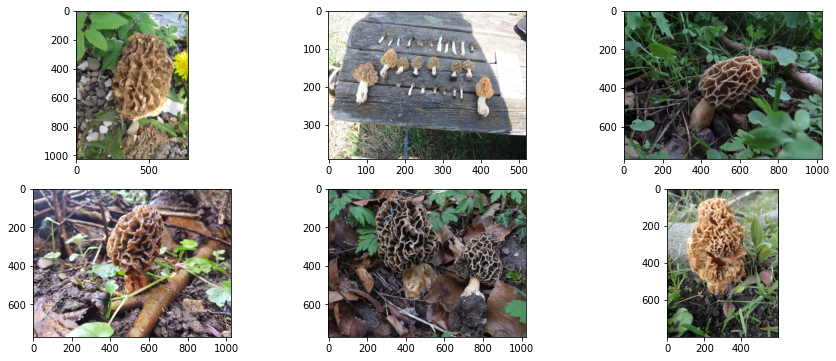

In [34]:
f, ax = plt.subplots(2, 3, figsize=(15, 6))
ax[0][0].imshow(PIL.Image.open(str(morchella_esculentas[0])))
ax[0][1].imshow(PIL.Image.open(str(morchella_esculentas[1])))
ax[0][2].imshow(PIL.Image.open(str(morchella_esculentas[2])))
ax[1][0].imshow(PIL.Image.open(str(morchella_vulgarises[0])))
ax[1][1].imshow(PIL.Image.open(str(morchella_vulgarises[1])))
ax[1][2].imshow(PIL.Image.open(str(morchella_vulgarises[2])))
plt.show()

In [35]:
def get_images_directory(directory):
    data_dir = pathlib.Path(directory)
    return data_dir

In [36]:
death_caps[0]

PosixPath('../raw_data/images/63478_Amanita_phalloides/LB2016-9174133_Hy4pgtC3.JPG')

# Getting images into API and Streamlit

In [50]:
from fastapi import FastAPI, File, UploadFile

In [56]:
image=PIL.Image.open(death_caps[1])
print(type(image))
image_array = np.array(image)
shape=image_array.shape
print(image_array.shape)
print(f'So every row has 1024 columns, each with a depth of 3, total elements:{shape[0]*shape[1]*shape[2]}')
print(f'\nThese are not bytes, as this does not bear a fixed relation to the filesize: {shape[0]*shape[1]*shape[2]/192203}')

<class 'PIL.JpegImagePlugin.JpegImageFile'>
(1000, 750, 3)
So every row has 1024 columns, each with a depth of 3, total elements:2250000

These are not bytes, as this does not bear a fixed relation to the filesize: 11.706372949433671


## Open the image as bytes to get a feel for how Fast API does it.

In [57]:
with open(death_caps[1], 'rb') as f:
    byte_im = f.read()
byte_im_array=np.asarray(bytearray(byte_im), dtype="uint8")
print(f'The size is {len(byte_im_array)/1000}K, the shape is {byte_im_array.shape}')
print(f'The type is {type(byte_im_array)}')
print(death_caps[1])

The size is 192.203K, the shape is (192203,)
The type is <class 'numpy.ndarray'>
../raw_data/images/63478_Amanita_phalloides/CUV2017-9224413_ByX-R1O3-.JPG


In [58]:
print('Confirm size using ls:')
!ls -rtlh \
'../raw_data/images/63478_Amanita_phalloides/CUV2017-9224413_ByX-R1O3-.JPG' \
| awk '{print $5}'

Confirm size using ls:
188K


#### ls consistently gives a smaller size in Kbytes.

### Trying to reshape this using just numpy doesn't work for some reason.

In [60]:
#X=np.reshape(byte_im_array,(224, 224, 3))
#plt.imshow(X);
print('This gives this error:\nValueError: cannot reshape array of size 192203 into shape (224,224,3)')

This gives this error:
ValueError: cannot reshape array of size 192203 into shape (224,224,3)


### But we can reshape it with cv.imdecode as Stella did.

The type of this is: <class 'numpy.ndarray'>; it's shape is (1000, 750, 3)


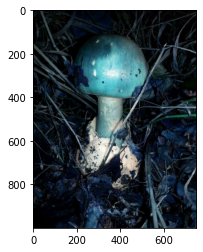

In [61]:
decode_img = cv.imdecode(byte_im_array,cv.IMREAD_COLOR)
print(f"The type of this is: {type(decode_img)}; it's shape is {decode_img.shape}")
plt.imshow(decode_img);

#### CV uses BGR and not RGB order, must correct this

See here:
https://stackoverflow.com/questions/52494592/wrong-colours-with-cv2-imdecode-python-opencv <br>
**matplotlib requires RGB ordering whereas OpenCV (perversely) uses BGR. I think you need to use cv2.cvtColor() to convert between the two.**

The type of this is: <class 'numpy.ndarray'>; it's shape is (1000, 750, 3)


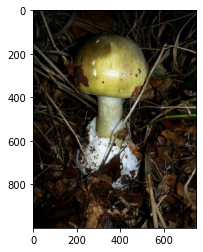

In [62]:
imageRGB = cv.cvtColor(decode_img , cv.COLOR_BGR2RGB)
print(f"The type of this is: {type(imageRGB)}; it's shape is {imageRGB.shape}")

plt.imshow(imageRGB);

### Let's do another way and see if they are different

The type of this is: <class 'PIL.JpegImagePlugin.JpegImageFile'>


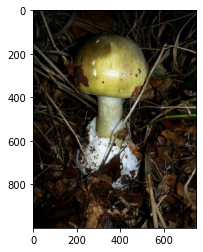

In [63]:
decode_img2 = PIL.Image.open(io.BytesIO(byte_im_array))
print(f"The type of this is: {type(decode_img2)}")
plt.imshow(decode_img2);

The type of this is: <class 'numpy.ndarray'>; it's shape is (1000, 750, 3)


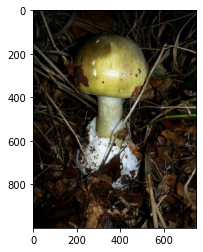

In [64]:
decode_img2_arr = np.asarray(decode_img2)
print(f"The type of this is: {type(decode_img2_arr)}; it's shape is {decode_img2_arr.shape}")
plt.imshow(decode_img2_arr);

In [65]:
#imageRGB==decode_img2_arr
np.array_equal(imageRGB, decode_img2_arr, equal_nan=False)

True

### Finally let's reshape it again with Keras so that it can get into Laura's model

#### Laura loads an image from a path and reshapes it in the loading

The type of this loaded image is: <class 'PIL.JpegImagePlugin.JpegImageFile'>


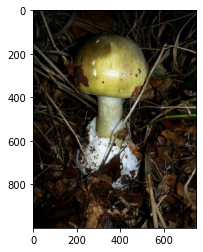

In [66]:
# Load with reshaping
img_height = 224
img_width  = 224
model_img_resize  = tf.keras.utils.load_img(death_caps[1], target_size=(img_height, img_width))

# Load without reshaping.
model_img  = tf.keras.utils.load_img(death_caps[1])
print(f'The type of this loaded image is: {type(model_img)}')
plt.imshow(model_img);

#### Use ImageChops from PIL library to compare this with our earlier PIL image

In [67]:
diff = ImageChops.difference(model_img, decode_img2)
if diff.getbbox():
    print("images are different")
else:
    print("images are the same")

images are the same


 <span style="color:blue"><span style="font-family:Papyrus; font-size:2em;">The images will be the same if we do not apply any reshaping. It is just that when you load in and reshape with keras, it does some interpolation.</span> </span>

#### We however do not want to do it this way, but to use an existing image.

In [71]:
img_height = 224
img_width  = 224
size=(img_width,img_height)

model_img_resize  = tf.keras.utils.load_img(death_caps[1], target_size=size)
print(type(model_img_resize))
decode_img2_resize=decode_img2.resize(size)
print(type(decode_img2_resize))

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>


In [72]:
diff = ImageChops.difference(model_img_resize, decode_img2_resize)
if diff.getbbox():
    print("images are different")
else:
    print("images are the same")

images are different


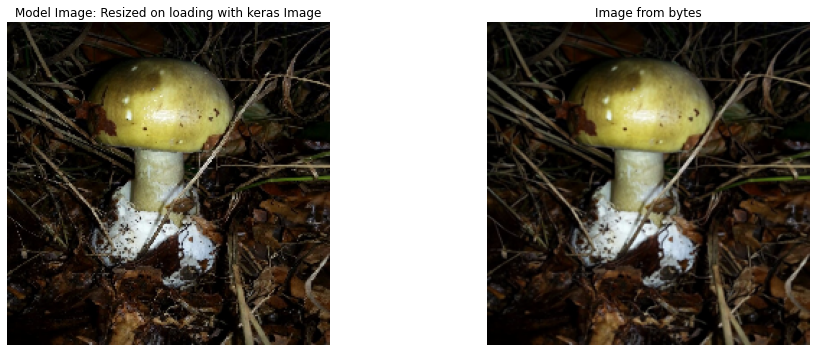

In [73]:
fig, ax = plt.subplots(1, 2, figsize = (15,5))
ax[0].imshow(model_img_resize)
ax[0].set_title('Model Image: Resized on loading with keras Image')

ax[1].imshow(decode_img2_resize)
ax[1].set_title('Image from bytes')
for ax in fig.axes:
    ax.axis('off')
plt.tight_layout()

**They don't look different to me**

In [75]:
print(type(decode_img2))
tf_resized_img=tf.image.resize(decode_img2,size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
print(type(tf_resized_img))
tf_resized_img_np=np.array(tf_resized_img)

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [76]:
print(tf_resized_img_np.shape)
np.array_equal(tf_resized_img_np, np.asarray(model_img_resize), equal_nan=False)

(224, 224, 3)


True

In [77]:
print(tf_resized_img_np.shape)
print(np.asarray(model_img_resize).shape)

(224, 224, 3)
(224, 224, 3)


# Passing image to model for prediction

## Load Model locally

### Load model

In [45]:
!ls -rtlh ../our_first_modelmodels_first_model
!ls -rtlh ../our_first_model/saved_model.pb

model=keras.models.load_model('../our_first_model/')
model

ls: cannot access '../our_first_modelmodels_first_model': No such file or directory
-rw-r--r-- 1 noel noel 389K Mar  3 18:08 ../our_first_model/saved_model.pb


**Note that we just specify the directory of the model, not the model itself. Either there is some internal variable which was set which tells it the name of the model to load, or else you can only have one model per directory, and it must always be named "saved_model.pb"**

### Run with image loaded exactly as Laura does

In [46]:
death_caps[1]

PosixPath('../raw_data/fungi_identification/images/63478_Amanita_phalloides/MAZ2016-9178960_Sk37EXr1l.JPG')

In [47]:
class_names = ['Edible', 'Poisonous']
size=(224,224)

head1='step'; head2='type'; head3='shape'
print(f'{head1:26} {head2:56} {head3:30}')

img_L  = tf.keras.utils.load_img(death_caps[1], target_size=size)
im_type=type(img_L); shape=img_L.size; descrip='Keras loaded resized image'
print(f'{descrip:26} {str(im_type):56} {str(shape):30}')

img_L = tf.keras.utils.img_to_array(img_L)
im_type=type(img_L); shape=img_L.size; descrip='Converted to np array'
print(f'{descrip:26} {str(im_type):56} {str(shape):30}')

img_L = tf.expand_dims(img_L, 0) # Create a batch
im_type=type(img_L); shape=img_L.shape; descrip='Tensorflow expanded image'
print(f'{descrip:26} {str(im_type):56} {str(shape):30}')

print('\n')
prediction = model.predict(img_L)
classif = int(prediction > .5)
print(f"This image most likely belongs to {class_names[classif]} with a score of: {prediction[0][0]:.5f}")

step                       type                                                     shape                         
Keras loaded resized image <class 'PIL.Image.Image'>                                (224, 224)                    
Converted to np array      <class 'numpy.ndarray'>                                  150528                        
Tensorflow expanded image  <class 'tensorflow.python.framework.ops.EagerTensor'>    (1, 224, 224, 3)              


This image most likely belongs to Edible with a score of: 0.41462


In [48]:
prediction = model.predict(img_L)
classif = int(prediction > .5)
print(f"This image most likely belongs to {class_names[classif]} with a score of: {prediction[0][0]:.5f}")

This image most likely belongs to Edible with a score of: 0.41462


### Run with image as it will arrive in API

In [49]:
# Get bunch of bites and look at size etc.
with open(death_caps[1], 'rb') as f:
    im_API = f.read()
im_API=np.asarray(bytearray(im_API), dtype="uint8")
print(f'The size of the file is {len(im_API)/1000}K\n') 


head1='step'; head2='type'; head3='shape'
print(f'{head1:26} {head2:56} {head3:30}')

im_type=type(im_API); shape=im_API.size; descrip='Image from API as bytes'
print(f'{descrip:26} {str(im_type):56} {str(shape):30}')


# decode these back into image form with cv.imdecode
im_API = cv.imdecode(im_API,cv.IMREAD_COLOR)
# cv.imdecode uses BGR and not RGB so we must adjust this using cv.cvtColor
im_API = cv.cvtColor(im_API , cv.COLOR_BGR2RGB)
im_type=type(im_API); shape=im_API.shape; descrip='CV Decoded image'
print(f'{descrip:26} {str(im_type):56} {str(shape):30}')



# resize using tensor flows resize with nearest neighbour interpolation to be similar to 
# what is done with that loading function. Though we know there remains some difference.
im_API=tf.image.resize(im_API,size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
im_type=type(im_API); shape=im_API.shape; descrip='Tensorflow resized image'
print(f'{descrip:26} {str(im_type):56} {str(shape):30}')

im_API = tf.expand_dims(im_API, 0) # Create a batch
im_type=type(im_API); shape=im_API.shape; descrip='Tensorflow expanded image'
print(f'{descrip:26} {str(im_type):56} {str(shape):30}')


print('\n')
prediction = model.predict(im_API)
classif = int(prediction > .5)
print(f"This image most likely belongs to {class_names[classif]} with a score of: {prediction[0][0]:.5f}")

The size of the file is 224.192K

step                       type                                                     shape                         
Image from API as bytes    <class 'numpy.ndarray'>                                  224192                        
CV Decoded image           <class 'numpy.ndarray'>                                  (800, 600, 3)                 
Tensorflow resized image   <class 'tensorflow.python.framework.ops.EagerTensor'>    (224, 224, 3)                 
Tensorflow expanded image  <class 'tensorflow.python.framework.ops.EagerTensor'>    (1, 224, 224, 3)              


This image most likely belongs to Edible with a score of: 0.41462


### Make sure that both image aquisition tecnhniques always produce close results

In [50]:
def image_API(im_path):
    # convert to bites (this step should be excluded in an actual API, as the
    # image arrives in bytes from the get or post functions.)
    with open(im_path, 'rb') as f:
        im_API = f.read()
    # convert to np array.    
    im_API=np.asarray(bytearray(im_API), dtype="uint8")
    # decode byte array back into image, and then adjust
    # for cv's automatic BGR representation
    im_API = cv.imdecode(im_API,cv.IMREAD_COLOR)
    im_API = cv.cvtColor(im_API , cv.COLOR_BGR2RGB)
    
    # resize using tensor flow with nearest neighbour interpolation
    im_API=tf.image.resize(im_API,size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # Expand for CNN
    im_API = tf.expand_dims(im_API, 0) 
    
    return im_API

In [51]:
def image_laura(im_path):
    # Load with keras
    img_L  = tf.keras.utils.load_img(im_path, target_size=size)
    # Convert to np array
    img_L = tf.keras.utils.img_to_array(img_L)
    # Expand for CNN
    img_L = tf.expand_dims(img_L, 0) # Create a batch
    
    return img_L

In [52]:
for death_cap in death_caps:
    
    prediction_L=model.predict(image_laura(death_cap))
    classif_L = int(prediction_L > .5)
    
    prediction_API=model.predict(image_API(death_cap))
    classif_API = int(prediction_API > .5)
    print(f'{prediction_L[0][0]:.5f}:{class_names[classif_L]:10} {prediction_API[0][0]:.5f}:{class_names[classif_API]:10}')

0.61826:Poisonous 0.61699:Poisonous
0.41462:Edible 0.41462:Edible
0.51634:Poisonous 0.51634:Poisonous
0.70915:Poisonous 0.71035:Poisonous
0.67330:Poisonous 0.68011:Poisonous
0.54003:Poisonous 0.54003:Poisonous
0.56309:Poisonous 0.55980:Poisonous
0.63547:Poisonous 0.63547:Poisonous
0.41944:Edible 0.41884:Edible
0.29583:Edible 0.29935:Edible
0.60579:Poisonous 0.60651:Poisonous
0.55810:Poisonous 0.56344:Poisonous
0.63824:Poisonous 0.63862:Poisonous
0.59749:Poisonous 0.60017:Poisonous
0.36543:Edible 0.36543:Edible
0.52481:Poisonous 0.52181:Poisonous
0.60419:Poisonous 0.60187:Poisonous
0.24366:Edible 0.24792:Edible
0.22312:Edible 0.22111:Edible
0.55217:Poisonous 0.55217:Poisonous
0.66076:Poisonous 0.66194:Poisonous
0.35166:Edible 0.35081:Edible
0.56019:Poisonous 0.55443:Poisonous
0.67189:Poisonous 0.67359:Poisonous
0.66296:Poisonous 0.66709:Poisonous
0.35827:Edible 0.35923:Edible
0.41719:Edible 0.41719:Edible
0.42551:Edible 0.42551:Edible
0.41818:Edible 0.42147:Edible
0.71598:Poisonous 0.71

**So we see the two image loadings give the same score, but the model is not very good**

## Load from gcp

### Simple homemade way

In [53]:
print(BUCKET_NAME)
print(STORAGE_LOCATION)

mushroom-bucket-le-wagon
models/first_model


#### This way works, but the loaded model does not.

In [65]:
! rm ./saved_model.pb

In [66]:
client = storage.Client()
bucket = client.bucket(BUCKET_NAME)
blob = bucket.blob(STORAGE_LOCATION)
blob.download_to_filename('saved_model.pb')
#model=keras.models.load_model('.')
print("this would give error:\nOSError: Cannot parse file b'./saved_model.pb': Error parsing message with type 'tensorflow.SavedModel'.")

this would give error:
OSError: Cannot parse file b'./saved_model.pb': Error parsing message with type 'tensorflow.SavedModel'.


In [67]:
!ls -rtlh ./saved_model.pb

-rw-r--r-- 1 noel noel 18 Mar  7 07:31 ./saved_model.pb


#### Brute force gsutil method

In [55]:
! gsutil cp gs://mushroom-bucket-le-wagon/models/first_model  .

Copying gs://mushroom-bucket-le-wagon/models/first_model...
/ [1 files][   18.0 B/   18.0 B]                                                
Operation completed over 1 objects/18.0 B.                                       


In [56]:
ls -rlth ./first_model

-rw-r--r-- 1 noel noel 18 Mar  7 07:29 ./first_model


In [57]:
#model=keras.models.load_model('.')
print("This would also give error:\nOSError: Cannot parse file b'./saved_model.pb': Error parsing message with type 'tensorflow.SavedModel'.")

This would also give error:
OSError: Cannot parse file b'./saved_model.pb': Error parsing message with type 'tensorflow.SavedModel'.


**Seems the model saved on gcp has the wrong extension or something. Either way we have it.**

### Using load_from_gcp

In [58]:
from mushroom_learning.gcp import load_from_gcp

 <span style="color:blue"><span style="font-family:Papyrus; font-size:2em;">We will put the .env file in our notebooks folder here. DONT FORGET TO DELETE.</span> </span>

In [59]:
print(os.environ['gcp_json_path'])
storage_client = storage.Client.from_service_account_json(os.getenv("gcp_json_path"))

/home/noel/Bureau/omega-clarity-337815-7177e76f8542.json


In [60]:
#model = load_from_gcp()
print('This gives this error')
print("RefreshError: ('invalid_grant: Invalid JWT Signature.', {'error': 'invalid_grant', 'error_description': 'Invalid JWT Signature.'})")

This gives this error
RefreshError: ('invalid_grant: Invalid JWT Signature.', {'error': 'invalid_grant', 'error_description': 'Invalid JWT Signature.'})


https://medium.com/google-cloud/jwt-json-web-tokens-errors-invalid-jwt-signature-8aab13703eb5

When we look at this function, it seems it is not loading it from GCP anyway. It loads it from local storage using this function.

In [61]:
LOCAL_STORAGE_PATH =  "../our_first_model"
def get_model():
        print(LOCAL_STORAGE_PATH)
        return keras.models.load_model(LOCAL_STORAGE_PATH)
model=get_model()

../our_first_model
